In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(720, 1280, 3)


In [3]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat2.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_cat = cv2.imread(img_path) 
print (img_cat.shape)

(1280, 1280, 3)


In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [5]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [6]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(720, 1280, 3) (288, 513, 3) 15


In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### 아웃포커스 인물사진

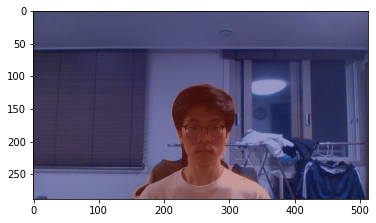

In [8]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

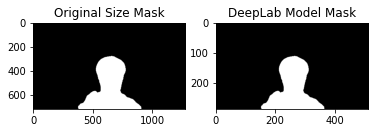

In [9]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

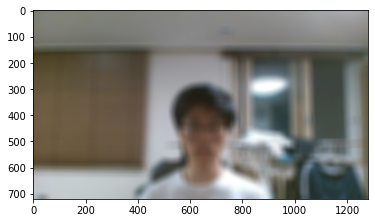

In [10]:
img_orig_blur = cv2.blur(img_orig, (33,33))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

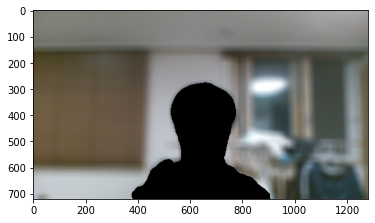

In [11]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

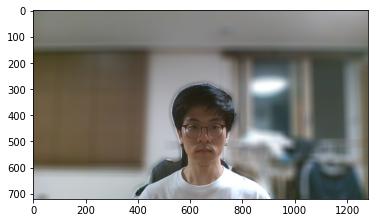

In [12]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

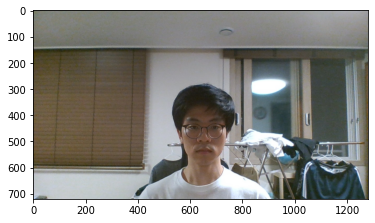

In [13]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
img_check = np.where(img_mask_color==255, img_orig, img_bg_mask)
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/test.png'
cv2.imwrite(img_path,img_check)

True

### 아웃포커스 고양이사진

In [15]:
img_resized_cat, seg_map_cat = MODEL.run(img_cat)
print (img_cat.shape, img_resized_cat.shape, seg_map_cat.max())

(1280, 1280, 3) (513, 513, 3) 8


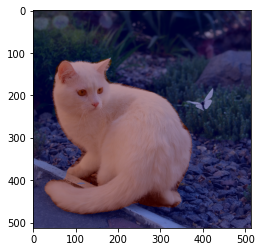

In [16]:
img_show_cat = img_resized_cat.copy()
seg_map_cat = np.where(seg_map_cat == 8, 8, 0) # 예측 중 고양이만 추출
img_mask_cat = seg_map_cat * (255/seg_map_cat.max()) # 255 normalization
img_mask_cat = img_mask_cat.astype(np.uint8)
color_mask_cat = cv2.applyColorMap(img_mask_cat, cv2.COLORMAP_JET)
img_show_cat = cv2.addWeighted(img_show_cat, 0.6, color_mask_cat, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show_cat, cv2.COLOR_BGR2RGB))
plt.show()

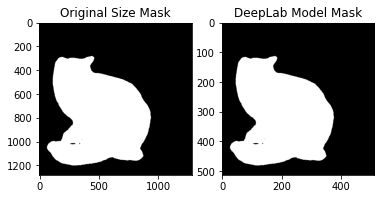

In [17]:
img_mask_up_cat = cv2.resize(img_mask_cat, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_cat = cv2.threshold(img_mask_up_cat, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_cat, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_cat, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

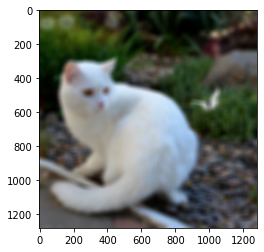

In [18]:
img_cat_blur = cv2.blur(img_cat, (33,33))
plt.imshow(cv2.cvtColor(img_cat_blur, cv2.COLOR_BGR2RGB))
plt.show()

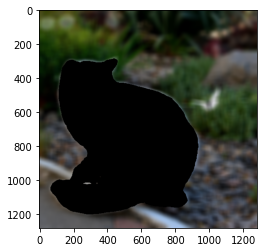

In [19]:
img_mask_color_cat = cv2.cvtColor(img_mask_up_cat, cv2.COLOR_GRAY2BGR)
img_bg_mask_cat = cv2.bitwise_not(img_mask_color_cat)
img_bg_blur_cat = cv2.bitwise_and(img_cat_blur, img_bg_mask_cat)
plt.imshow(cv2.cvtColor(img_bg_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

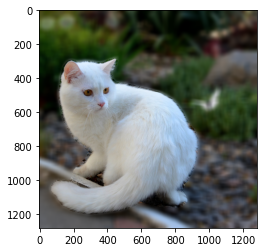

In [20]:
img_concat_cat = np.where(img_mask_color_cat==255, img_cat, img_bg_blur_cat)
plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))
plt.show()

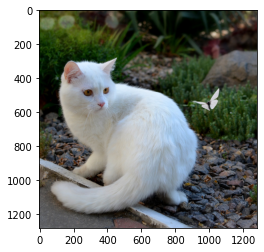

In [21]:
plt.imshow(cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB))
plt.show()

### 배경전환

In [22]:
height, width = img_orig.shape[:2]
img_bg = cv2.resize(img_cat, (width, height), interpolation = cv2.INTER_CUBIC )

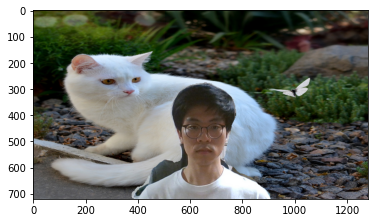

In [23]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 인물사진에서 발생한 문제점

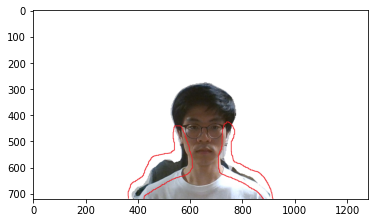

In [24]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/test2.png'
img_tmp = cv2.imread(img_path) 
plt.imshow(cv2.cvtColor(img_tmp, cv2.COLOR_BGR2RGB))
plt.show()

segmentation을 통해 인물을 추출했을 때 사진을 크게 확대해서 보면 머리카락 가장자리에도 배경이 일부 포함되어 있다. 완벽하진 않지만 큰 문제점은 아니라고 생각된다. 하지만 어깨와 목 주변의 경우 배경이 많이 포함되는 문제점이 발생하였다. segmentation 과정을 개선하여 문제점을 해결할 필요가 있다.
segmentation 과정에서 labeling에서 문제가 발생한다. labeling 과정에서 물체의 일부가 누락되거나 검출된 여러 edge 중 어느 edge를 물체의 edge로 판단하는지에 따라 segmentation 결과가 크게 달라진다.

### segmentation 개선

3D Depth Camera 활용 : 카메라가 두개 필요하다
IR(적외선)을 활용 : 적외선 카메라가 필요하다

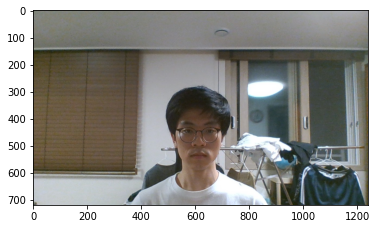

In [25]:
num=40
limg=cv2.cvtColor(img_orig[:,num:], cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(img_orig[:,num:], cv2.COLOR_BGR2RGB))
plt.show()

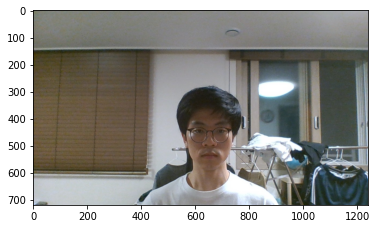

In [26]:
rimg=cv2.cvtColor(img_orig[:,:-num], cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(img_orig[:,:-num], cv2.COLOR_BGR2RGB))
plt.show()

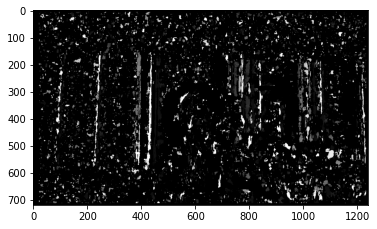

In [27]:
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(limg, rimg)

plt.imshow(disparity,'gray')
plt.show()

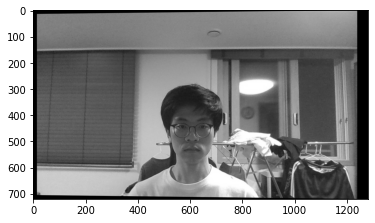

In [28]:
n=15
pts1 = np.float32([[0, height], [width, height], [0,0], [width, 0]])
pts2 = np.float32([[0+n, height-n], [width, height], [0+n,0+n], [width, 0]])
mtrx = cv2.getPerspectiveTransform(pts1, pts2)
limg2 = cv2.warpPerspective(limg, mtrx, (width, height),flags=cv2.INTER_CUBIC)

plt.imshow(cv2.cvtColor(limg2, cv2.COLOR_BGR2RGB))
plt.show()

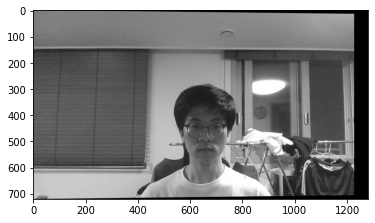

In [29]:
pts1 = np.float32([[0, height], [width, height], [0,0], [width, 0]])
pts2 = np.float32([[0, height], [width-n, height-n], [0,0], [width-n, 0+n]])
mtrx = cv2.getPerspectiveTransform(pts1, pts2)
rimg2 = cv2.warpPerspective(rimg, mtrx, (width, height),flags=cv2.INTER_CUBIC)

plt.imshow(cv2.cvtColor(rimg2, cv2.COLOR_BGR2RGB))
plt.show()


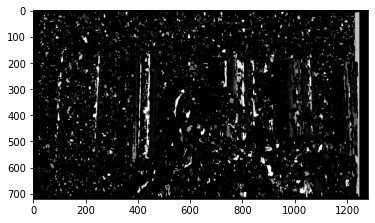

In [30]:
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(limg2, rimg2)

plt.imshow(disparity,'gray')
plt.show()

두 개의 카메라를 통한 depth 정보 획득을 이미지 변환을 이용하여 할 수 있을지 궁금하였다. 이미지를 변형해서 하나의 이미지를 두 개의 카메라로 촬영한 것 처럼 만들어 보려 시도했다. 하지만 depth 정보 획득에는 실패하였다.

깊이 영상(Depth image) 활용하기를 읽고 frame sequence를 이용한 훈련을 통해 depth를 구할 수 있다는 것을 알게 되었다. 이미지의 테두리를 잘라내고 확대하여 frame-1이나 frame+1로 이용할 수 있지 않을까 생각하였다. 하지만 이를 이용하여 모델 훈련이 제대로 가능한지, depth 정보 획득이 가능한지는 능력이 부족하여 수행하지 못하였다.

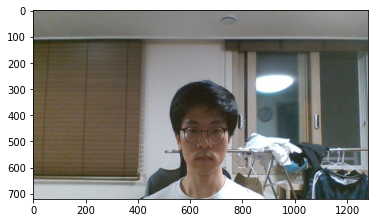

In [31]:
height, width = img_orig.shape[:2]
crop_img=img_orig[50:-50,50:-50]
img_result = cv2.resize(crop_img, (width, height), interpolation = cv2.INTER_CUBIC )
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.show()

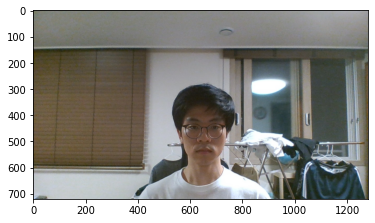

In [32]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

Kitti 데이터셋으로 훈련된 monodepth2 모델을 이용하여 depth 정보를 확인해 보았다.

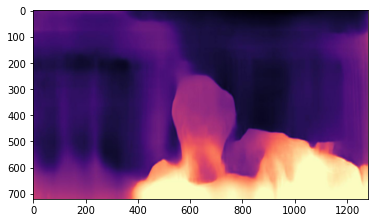

In [33]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image_disp.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_disp = cv2.imread(img_path) 
plt.imshow(cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB))
plt.show()

기존 알고리즘으로 segmentation 했을 때 잘못 포함된 배경이 monodepth2 모델을 활용했을 때 다른 색으로 보인다. monodepth2 결과를 그대로 활용하기에는 문제점이 있다. segmentation 목적에 맞는 적절한 데이터셋을 이용하여 훈련시키고, 기존에 사용한 알고리즘과 함께 edge 선택에 추가적인 정보로 활용한다면 보다 성능이 뛰어난 segmentation이 가능할 것으로 보인다.